# M-Test Notes

** Overview **

1. Implemented M-test based on Kolmogorov-Smirnov statistics on $M_w$ and Fisher's combined test.
2. Rejected null hypothesis with large significance for all models in stochastic event set.
3. Due to sampling differences between catalog and forecast and harshness of test with large $N$. This might effect the estimation of the ECDF function.
4. Alternatives: 
 - Method like Turnbull et al., 1976 to estimate distribution function for censored data.
 - Pivot from ECDF style tests to something that discretizes magnitude and uses empirically likelihood (ie., event counts in magnitude bins).
 - Switch to Kramer-von Mises or Anderson-Darling test.
 
Notes:
 - Discrete KS critical values
 - Better understand deficiencies with observed catalogs.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from csep.utils.plotting import plot_mfd
import csep
import csep.utils.stats as cstats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load Comcat catalog and UCERF3 forecasts

In [2]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > 3.95')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 8.551115989685059 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 3.9600000381469727 and Max Magnitude: 6.300000190734863



In [3]:
# UCERF3 stochastic event set
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

u3catalogs = []
for cat in csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs.append(cat.filter('magnitude > 3.95'))

## Towards an M-test

The M-test or Magnitude-test evaluates whether the magnitude-frequency distribution (MFD) of the observed catalog is statistically different than the forecast. There exist several techniques to compare whether two samples originate from the same population distribution; such as, Kolmogorov-Smirnov, Kramer-von Mises, or Anderson-Darling for continuous distributions and exact Multinomial test or Chi-square for discrete distributions. The Kolmogorov-Smirnov test is the most straightforward to implement because the distribution of the test statistic has an analytical distribution function; however, this test tends to be more sensitive to values in the middle of the probability distributions.

Two-sample non-parameteric tests for equality require computing empirical distribution functions from observed data sets. It's typical that magnitudes of earthquake forecasts and catalogs are discretized so that only certain observation are possible within a data set. The plots below show how the different discretizations effect the estimation of the KS statistics which is defined as $\sup{\lvert F(x)-G(x) \rvert}$, where $F(x)$ and $G(x)$ are empirical distribution functions.


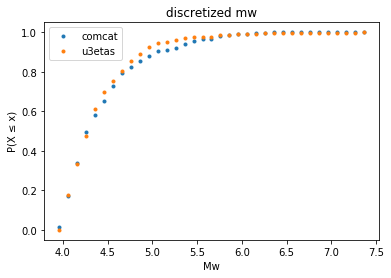

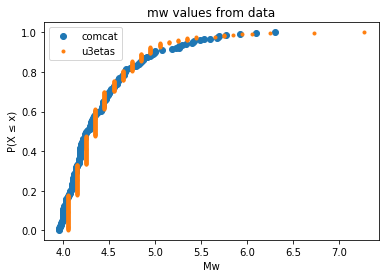

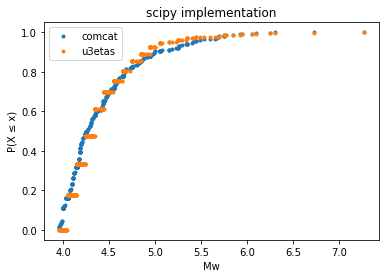

In [4]:
obs = comcat.get_magnitudes()
u3etas = u3catalogs[0].get_magnitudes()

# magnitude increment
dmw = 0.25
global_min = min([min(obs), min(u3etas)])
global_max = max([max(obs), max(u3etas)])

# magnitude bins
mws = arange(global_min, global_max+dmw, dmw)

# compute cdf function
# this computes ecdf everytime, can compute once and store. use different function
cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw), mws))
cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw), mws))

figure()
title("discretized mw")
plot(mws, cdf1, '.', label='comcat')
plot(mws, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

figure()
title("mw values from data")
plot(*cstats.ecdf(obs), 'o', label='comcat')
plot(*cstats.ecdf(u3etas), '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

# plotting ecdf from scipy implementation
d1 = sort(obs)
d2 = sort(u3etas)
n1 = d1.shape[0]
n2 = d2.shape[0]
d_all = concatenate([d1, d2])
cdf1 = searchsorted(d1, d_all, side='right') / n1
cdf2 = searchsorted(d2, d_all, side='right') / n2

figure()
title("scipy implementation")
plot(d_all, cdf1, '.', label='comcat')
plot(d_all, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
h = legend()

The top figure defines an arbitrary set of $M_w$ values to compute the ECDF so that the KS statistics is computed at consistent frequencies between the simulation and the data.

The middle figure defines cumulative frequencies at only points defined by the data. This operation produces an ambiguous KS statistic because there are multiple cumulative frequencies for each catalog value. We can immediately discard this approach.

The bottom figure shows the scipy implementation which pools the data under the null-hypothesis and computes cumulative frequencies for each value in the pooled data. This approach does not suffer the same issue as seen in the middle figure. However, by defining cumulative frequncies at values not observed in the catalog, the resulting KS statistics are potentially larger than they would be in the top case.

### Implementation of KS test using Discretized $M_w$ approach

To compare against the scipy implementation, we use the following implementation for the two-sample KS test based on computing the emprical distribution function at discretized values.

In [5]:
import scipy

def my_ks_2samp(data1, data2, dmw=0.1):
    # real version should force to be numpy arrays, etc.
    
    global_min = min([min(data1), min(data2)])
    global_max = max([max(data1), max(data2)])
    
    mws = arange(global_min, global_max+2*dmw, dmw)
    
    # precompute the ecdf so it only happens once
    cdf1_all = cstats.ecdf(data1)
    cdf2_all = cstats.ecdf(data2)
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(data1, mw, cdf=cdf1_all), mws))
    cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(data2, mw, cdf=cdf2_all), mws))
        
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    cdf1 = np.array(cdf1)
    cdf2 = np.array(cdf2)
    
    d = np.max(np.absolute(cdf1-cdf2))
    en = np.sqrt(n1 * n2 / (n1 + n2))
    
    # the constants are from stephens, 1974. seem to be simplification for computing sqrt(n). is this needed today?
    prob = scipy.stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
    
    return(d, prob)

## Testing the M-test

1. Generate collection of RVs from known distribution, called $M_0$.
2. Generate $N$ collections of RVs from same distribution in 1, called $M_i$.
3. For all $M_i$, perform KS test and aggreate p-values using methods above.

Since we are comparing two collections of RVs sampled from the same distribution we expect that the individual and aggregate statistics from the KS test reflect this.

### For Scipy Implementation

rejected 121 out of 1000 simluations.
3143.9398524680355 2.4114889003223736e-54


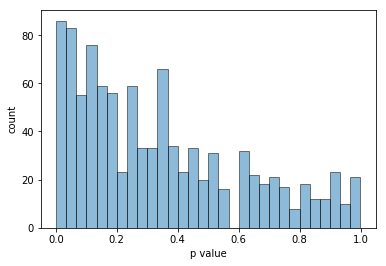

In [6]:
from scipy.stats import poisson, ks_2samp, norm
from scipy.stats.distributions import chi2

mu = 1.0
N = 1000
m0 = norm.rvs(mu, size=N)
mi = norm.rvs(mu, size=(N,N))
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = ks_2samp(m0, mi[idx])
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf()
p_values[p_values >= 1.0] = 1.0

print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

Rejected 161 out of 1000 simluations.
3580.343549237139 8.499205883648125e-93


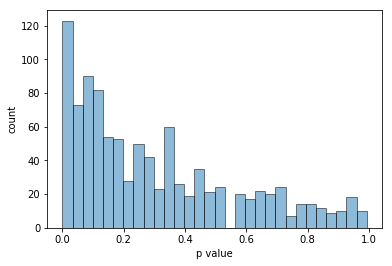

In [12]:
from scipy.stats import poisson, norm
from scipy.stats.distributions import chi2

mu = 0.0
N = 1000
m0 = norm.rvs(mu, size=N)
mi = norm.rvs(mu, size=(N,N))
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = my_ks_2samp(m0, mi[idx], dmw=0.25)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf()
p_values[p_values >= 1.0] = 1.0

print('Rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

The scipy implementation handles this test case appropriately. Based on this test, it appears that using a discrete distribution produces an incorrect type-I error rate for this test. 

Options: KS Test for discrete distributions or Anderson-Darling test.

## Testing the M-test using UCERF3

### For Scipy Implementation 

rejected 134 out of 9999 simluations.
11368.977749600002 1.0


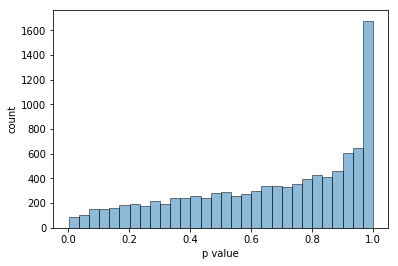

In [13]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = ks_2samp(m0_mws, mi_mws)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

rejected 47 out of 9999 simluations.
6811.407890264489 1.0


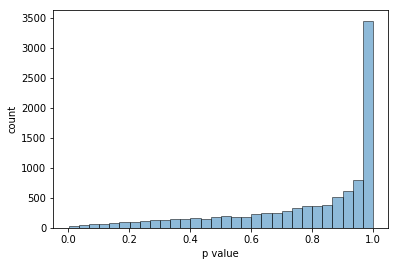

In [15]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = my_ks_2samp(m0_mws, mi_mws, dmw=0.25)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

These tests show that the implementation from scipy provides test results consistent with our observations, and can be used to implement the M-test. Possible alternative solution could be Turnbull [1976]. 

The type-I error seems to be off for this particular test. We expect a type-I error rate equal to $\alpha$.

## M-test of UCERF3-ETAS against observed data

rejected 545 out of 10000 simluations.
22971.457554253484 5.1050547061729145e-46


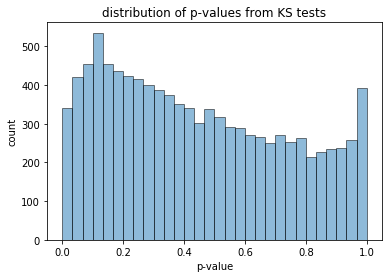

In [16]:
obs = comcat.get_magnitudes()
alpha = 0.05

rejections = 0
p_values = []

for u3cat in u3catalogs:
    mws = u3cat.get_magnitudes()
    d, p_val = my_ks_2samp(obs, mws, dmw=0.25)
    p_values.append(p_val)
    if p_val < alpha:
        rejections = rejections + 1
        
p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('p-value')
h = ylabel('count')
h = title('distribution of p-values from KS tests')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# display rejection
print('rejected {} out of {} simluations.'.format(rejections, len(u3catalogs)))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

## Conclusions

These notes show a possible implementation of the M-test based on Kolmogorov-Smirnov statistics. K-S statistics are based on estimating ECDFs and are very strict for large numbers of observations. This means that small deviations between the two result in rejecting the null-hypothesis.

It seems that this implementation might be too strict, for the overall purposes of the M-test. This raises the point that we might be interested in developing two-classes of tests: (1) developmental tests and (2) operational tests. These tests serve different purposes; namely, for model development and communication of forecast results. The developmental tests would be more severe and would be used to help modelers improve their models. The operational tests would be used to help communicate earthquake forecasts to the public and would likely be more qualitative in nature.

## Discussion

Our test implementation using the scipy implementation produces constisent results for both Poisson and UCERF-ETAS tests. However, on first glace, the test appears to be overly strict for the purposes of CSEP. The current M-test implementation asks "Do the forecast and the observation originate from the same distribution function?", but we are actually asking if the simulated and observed magnitude-frequency distributions are consistent with one another.

We reject the null-hypothesis for all simulations in the stochastic event set. Using Fisher's combined test we reject the collection of tests as a whole. This poses some questions in regards to this implementation of the M-test using the scipy implementation of KS statistics. 

The KS statistic is based on the the maximum absolute distance between the observed and cumulative distribution functions. It seems that we are biasing the estimation of this parameter by treating the censored data points. This was meant to be solved by computing the empirical distribution functions at evenly discretized points.

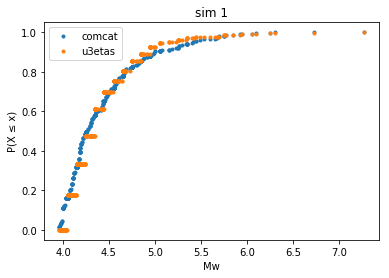

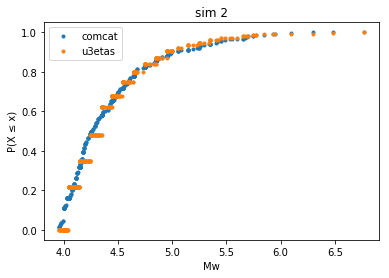

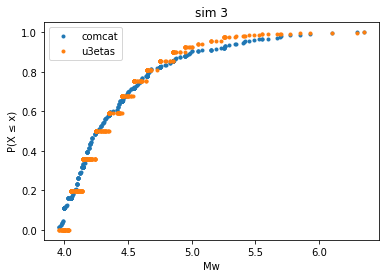

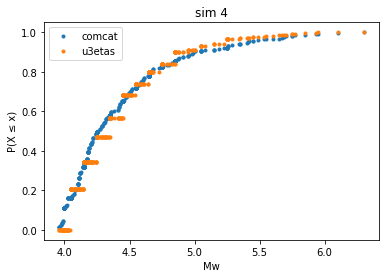

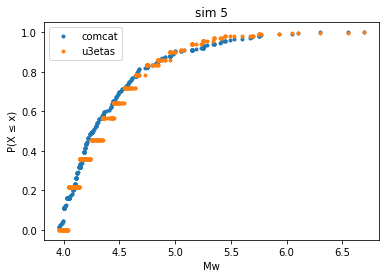

In [17]:
# plotting ecdf from scipy implementation
n_plots = 5
for idx in range(n_plots):
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    d1 = sort(obs)
    d2 = sort(u3etas)
    n1 = d1.shape[0]
    n2 = d2.shape[0]
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2

    figure()
    title("sim {}".format(idx+1))
    plot(d_all, cdf1, '.', label='comcat')
    plot(d_all, cdf2, '.', label='u3etas')
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

These figures show the empirical distribution functions used to compute the KS statistics used in the M-test. Visually, these plots indicate that the forecast ECDFs are seemingly consistent with the observed values.

Another way of implementing this test would be to discretize the magnitude bins and compute empirical distributions for the counts of the magnitudes in each bin. It seems that the forecast does not actually sample from the same distribution as the process generating seismicity, so this test will likely fail. Therefore, it seems more useful to devise a test that answers whether the forecast is consistent with the data.

### Testing discretization of data before computing ECDF

The discretization above uses the definition of the CDF to estimate the rank statistics of data at pre-defined intervals. Here, we will try to discretize the data before computing the KS statistics to see if this introduces any biases. I'll use the scipy implementation of the KS test.

In [18]:
def discretize(data, bin_edges):
    """
    returns array with len(bin_edges) consisting of the discretized values from each bin. 
    instead of returning the counts of each bin, this will return an array with values 
    modified such that any value within bin_edges[0] <= x_new < bin_edges[1] ==> x_new.
    """
    n = data.shape[0]
    idx = digitize(data, bins=bin_edges)
    x_new = bin_edges[idx].copy()
    return x_new
    

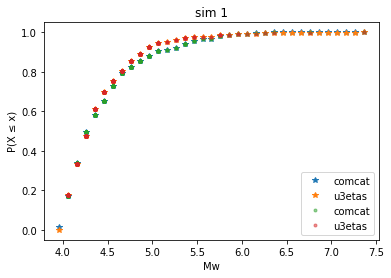

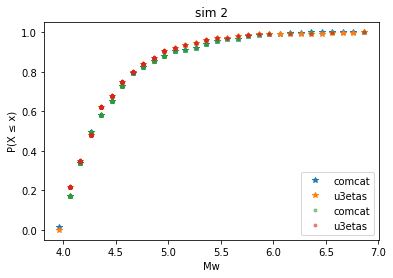

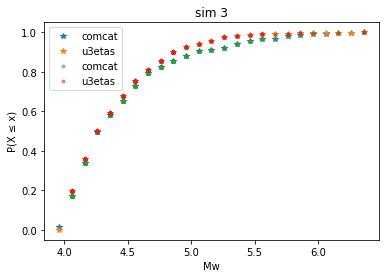

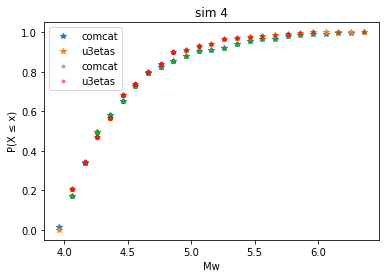

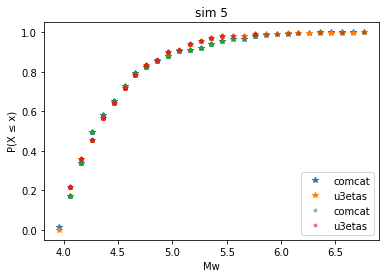

In [19]:
n_plots = 5
for idx in range(n_plots):
    # read catalogs
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3etas), min(obs)])
    global_max = max([max(u3etas), max(obs)])
    mws = arange(global_min, global_max+dmw, dmw)
    # discretize both data and forecast
    obs_disc = discretize(obs, mws)
    u3etas_disc = discretize(u3etas, mws)    
    # compute cdf based on KS method
    n1 = obs_disc.shape[0]
    n2 = u3etas_disc.shape[0]
    d1 = sort(obs_disc)
    d2 = sort(u3etas_disc)
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1_p = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw), mws))
    cdf2_p = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw), mws))

    figure()
    title("sim {}".format(idx+1))
    plot(mws, cdf1_p, '*', label='comcat')
    plot(mws, cdf2_p, '*', label='u3etas')
    plot(d_all, cdf1, '.', label='comcat', alpha=0.5)
    plot(d_all, cdf2, '.', label='u3etas', alpha=0.5)
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

As expected, makes no difference to discretize first then compute the ECDF or compute the ECDF at discrete points. For the Anderson-Darling approach, we will discretize the data and observations and then use the mid-rank approach to handle the discrete case. 

### Anderson-Darling test in place of K-S test synthetic test with true Null hypothesis 

/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1676: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


rejected 520 out of 9999 simluations.
17848.22442144609 1.0


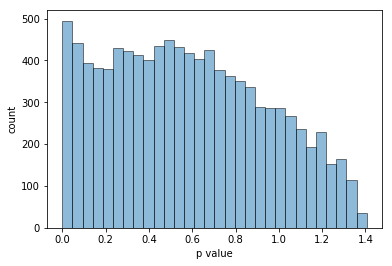

In [21]:
from scipy.stats import anderson_ksamp

m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05
dmw = 0.25

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(m0_mws), min(mi_mws)])
    global_max = max([max(m0_mws), max(mi_mws)])
    mws = arange(global_min, global_max+2*dmw, dmw)
    # get discretized vectors
    m0_disc = discretize(m0_mws, mws)
    mi_disc = discretize(mi_mws, mws)
    a_stat, crit_vals, p_value = anderson_ksamp([m0_disc, mi_disc])
    # special for anderson-darling
    p_values.append(p_value)
    if a_stat >= crit_vals[2]:
        rejections = rejections + 1

p_values = np.array(p_values)
# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps or extrapolation. 
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### Anderson-Darling test against Data

/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1676: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


rejected 1289 out of 10000 simluations.


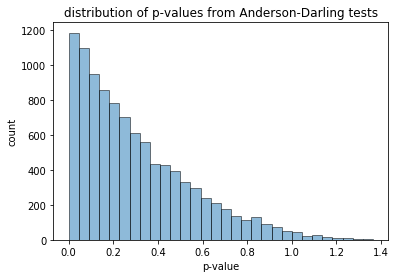

In [23]:
alpha = 0.05
dmw = 0.25
rejections = 0
p_values = []
obs = comcat.get_magnitudes()
for u3cat in u3catalogs:
    u3mws = u3cat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3mws), min(obs)])
    global_max = max([max(u3mws), max(obs)])
    mws = arange(global_min, global_max+2*dmw, dmw)
    # get discretized vectors
    u3_disc = discretize(u3mws, mws)
    obs_disc = discretize(obs, mws)
    a, crit, p_val = anderson_ksamp([u3_disc, obs_disc])
    p_values.append(p_val)
    # from scipy docs, idx=2 represents 5% significance
    if a >= crit[2]:
        rejections = rejections + 1
        
p_values = np.array(p_values)
# some issue with p_values, maybe related to scipy implementation of ks.sf() or extrapolation.
# use these values with care
# p_values[p_values >= 1.0] = 1.0
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('p-value')
h = ylabel('count')
h = title('distribution of p-values from Anderson-Darling tests')

# display rejection
print('rejected {} out of {} simluations.'.format(rejections, len(u3catalogs)))

### Visualizing the variability of the ECDF

The plots below show the first $N$ catalogs and the MFD from the data. 

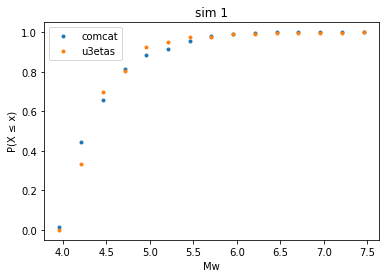

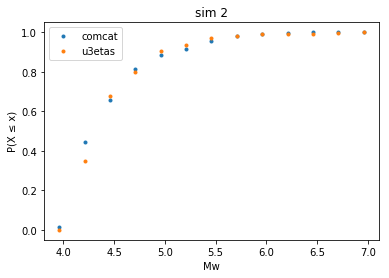

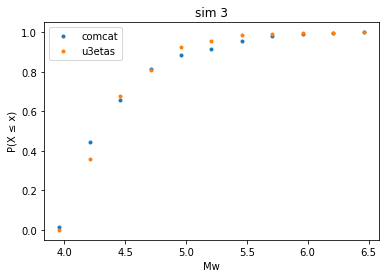

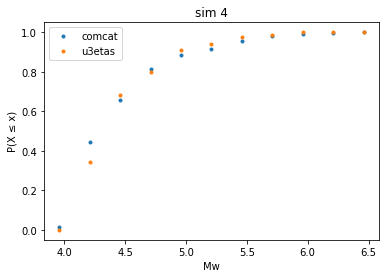

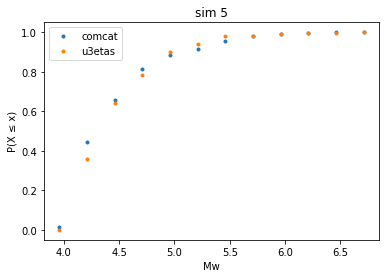

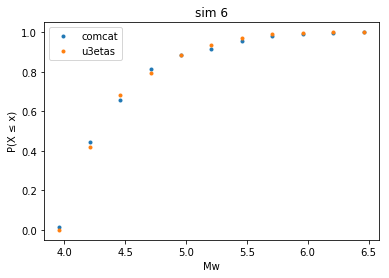

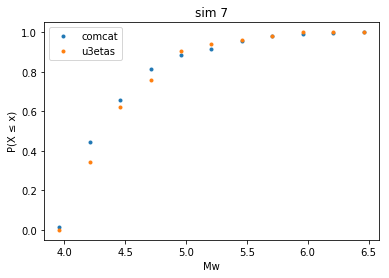

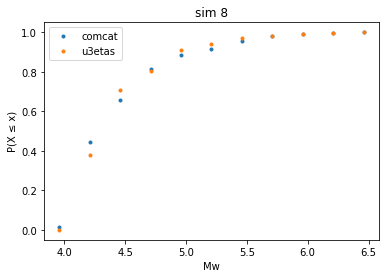

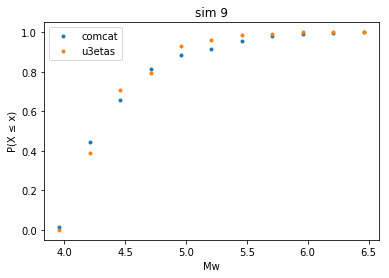

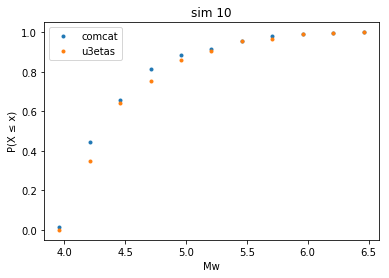

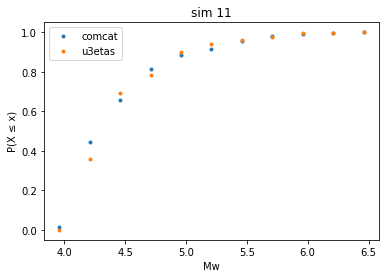

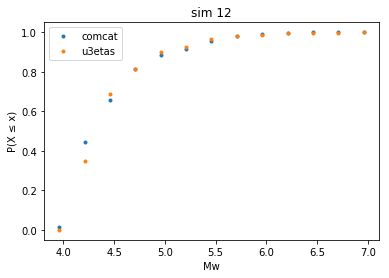

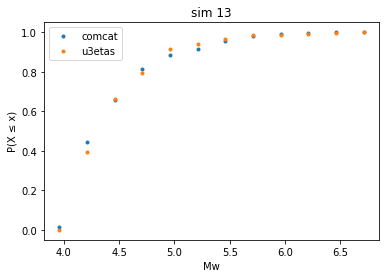

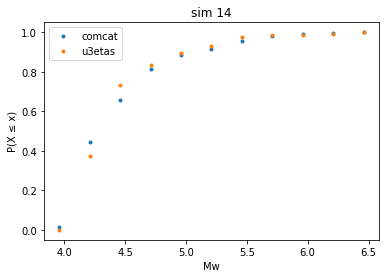

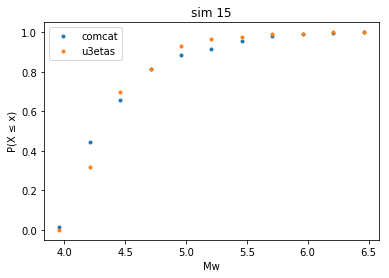

In [24]:
n_plots = 15
for idx in range(n_plots):
    # read catalogs
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3etas), min(obs)])
    global_max = max([max(u3etas), max(obs)])
    mws = arange(global_min, global_max+dmw, dmw)
    # discretize both data and forecast
    obs_disc = discretize(obs, mws)
    u3etas_disc = discretize(u3etas, mws)    
    # compute cdf based on KS method
    n1 = obs_disc.shape[0]
    n2 = u3etas_disc.shape[0]
    d1 = sort(obs_disc)
    d2 = sort(u3etas_disc)
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1_a = cstats.ecdf(obs)
    cdf2_a = cstats.ecdf(u3etas)
    cdf1_p = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw, cdf=cdf1_a), mws))
    cdf2_p = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw, cdf=cdf2_a), mws))

    figure()
    title("sim {}".format(idx+1))
    plot(mws, cdf1_p, '.', label='comcat')
    plot(mws, cdf2_p, '.', label='u3etas')
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

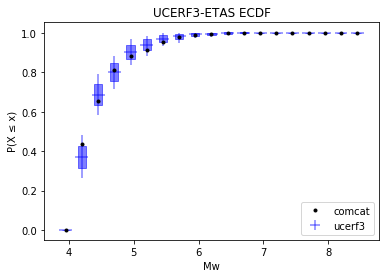

In [139]:
from matplotlib.collections import PatchCollection

def arbitrary_ecdf(x, vals):
    """
    returns the statement P(X ≤ x) for val in vals.
    vals must be monotonically increasing and unqiue.
    
    returns:
        tuple: sorted vals, and ecdf computed at vals
    """
    # precompute ecdf for x: returns(sorted(x), ecdf())
    ex, ey = cstats.ecdf(x)
    ecdf = numpy.array(list(map(lambda val: cstats.less_equal_ecdf(x, val, cdf=(ex, ey)), vals)))
    return (vals, ecdf)

def ks_from_ecdf(cdf1, cdf2, en):
    """
    computes k-s statistics given two cdfs: cdf1 and cdf2. 
    these should be defined at values observed in both data sets. 
    if used on discrete variables, the type-I error rates are too conservative.
    en = np.sqrt(n1*n2/float(n1+n2)); where n1 and n2 are the size of the original data
    """
    d = np.max(np.absolute(cdf1-cdf2))
    try:
        prob = stats.distributions.kstwobign.sf((en+0.12+0.11/en) * d)
    except:
        prob = 1.0
    return d, prob
    

mlow = 3.95
mhigh = 8.0
dmw = 0.25

# get list of magnitudes list of ndarray
u3etas_mws = list(map(lambda x: x.get_magnitudes(), u3catalogs))
obs_mw = comcat.get_magnitudes()

# get ecdf at arbitrary values
mws = np.arange(mlow, mhigh+2*dmw, dmw)

# get ecdf values 
u3etas_ecdf = np.array(list(map(lambda x: arbitrary_ecdf(x, mws), u3etas_mws)))
obs_ecdf = arbitrary_ecdf(obs_mw, mws)

fig = figure()
ax = fig.gca()
u3etas_median = np.median(u3etas_ecdf, axis=0)
u3etas_low = np.percentile(u3etas_ecdf, 2.5, axis=0)[1,:]
u3etas_high = np.percentile(u3etas_ecdf, 97.5, axis=0)[1,:]
u3etas_min = np.min(u3etas_ecdf, axis=0)[1,:]
u3etas_max = np.max(u3etas_ecdf, axis=0)[1,:]
u3etas_emin = u3etas_median[1,:]-u3etas_min
u3etas_emax = u3etas_max - u3etas_median[1,:]

# plot 95% range as rectangles
rectangles = []
for i in range(len(mws)):
    width = 0.5*dmw
    height = u3etas_high[i] - u3etas_low[i]
    xi = mws[i] - width / 2
    yi = u3etas_median[1,i] - height / 2
    rect = Rectangle((xi, yi), width, height)
    rectangles.append(rect)
pc = PatchCollection(rectangles, facecolor='blue', alpha=0.5, edgecolor='blue')
ax.add_collection(pc)
# plot whiskers
errorbar(*u3etas_median, xerr=0.8*dmw/2, yerr=[u3etas_emin, u3etas_emax], fmt=' ', label='ucerf3', color='blue', alpha=0.5)
plot(*obs_ecdf, '.k', label='comcat')
# # ax.set_yscale('log')
legend(loc='lower right')
xlabel('Mw')
ylabel('P(X ≤ x)')
title("UCERF3-ETAS ECDF")
savefig('/Users/wsavran/Desktop/best_looking_mfd.pdf')

ECDF for stochastic event set as compared with the Comcat catalog. We show Comcat with black dots and the UCERF distributions are visualized with these modified box and whisker plots. The boxes contain 95 percent of the data and the whiskers represen the extremes of the stochastic event set.

## References

Turnbull, B. W. (1976). The empirical distribution function with arbitrarily grouped, censored and truncated data. *Journal of the Royal Statistical Society. Series B (Methodological)*, 290-295.